In [2]:
# %pip install pandas numpy seaborn matplotlib scikit-learn sentence-transformers

### Importing Libraries ###

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer
from sklearn.tree import plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessing import clean_data
import matplotlib.pyplot as plt
import nltk

### Loading & Inspecting Data ###


In [4]:
# Loading Data
delta_df = pd.read_csv("datasets/Delta_Airline_Review_Dataset-Asof02172023.csv")
display(delta_df.head())

# Inspecting Data
print("----Data Info----\n")
print(delta_df.info())

print("\n----Data Shape----\n")
print(f'delta_df.shape: {delta_df.shape}')

print("\n----Data Stats----\n")
print(delta_df.describe())

print("\n----Data Null----\n")
print(delta_df.isnull().sum())


,Customer_ID,star rating,date,Seat Type,routes,traveler_types,country,reviews
0,1,4,17th February 2023,Economy Class,New York to Tel Aviv,Solo Leisure,United States,"✅ Trip Verified | First, travel starts 6pm ar..."
1,2,1,16th February 2023,Economy Class,Milwaukee to Ft Lauderdale,Business,United States,✅ Trip Verified | Delta did not issue any wea...
2,3,1,10th February 2023,Economy Class,New York to Charlotte,Business,United States,"✅ Trip Verified | Per our pilot, there would ..."
3,4,1,8th February 2023,Premium Economy,Atlanta to Cape Town,Family Leisure,United States,✅ Trip Verified | We flew from Atlanta to Cap...
4,5,2,6th February 2023,Economy Class,Dallas to Atlanta,Solo Leisure,United Kingdom,✅ Trip Verified | Checkin staff always seem u...


----Data Info----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer_ID     2689 non-null   int64 
 1   star rating     2689 non-null   int64 
 2   date            2689 non-null   object
 3    Seat Type      2689 non-null   object
 4   routes          2263 non-null   object
 5   traveler_types  2282 non-null   object
 6   country         2689 non-null   object
 7   reviews         2689 non-null   object
dtypes: int64(2), object(6)
memory usage: 168.2+ KB
None

----Data Shape----

delta_df.shape: (2689, 8)

----Data Stats----

       Customer_ID  star rating
count  2689.000000  2689.000000
mean   1345.000000     3.860915
std     776.391761     3.462060
min       1.000000     0.000000
25%     673.000000     1.000000
50%    1345.000000     2.000000
75%    2017.000000     8.000000
max    2689.000000    10.000000

----Data Null----

Cu

### Cleaning Data ###

In [5]:
cleaned_delta_df = clean_data(delta_df)
print(f'cleaned_delta_df.shape: {cleaned_delta_df.shape}')
display(cleaned_delta_df.head())

----Data Cleaned----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Customer_ID     2689 non-null   int64         
 1   star rating     2689 non-null   int64         
 2   date            2689 non-null   datetime64[ns]
 3    Seat Type      2689 non-null   object        
 4   routes          2689 non-null   object        
 5   traveler_types  2689 non-null   object        
 6   country         2689 non-null   object        
 7   reviews         2689 non-null   object        
 8   sentiment       2689 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(5)
memory usage: 170.9+ KB
None

Null values:
 Customer_ID       0
star rating       0
date              0
 Seat Type        0
routes            0
traveler_types    0
country           0
reviews           0
sentiment         0
dtype: int64

Se

,Customer_ID,star rating,date,Seat Type,routes,traveler_types,country,reviews,sentiment
0,1,4,2023-02-17,economy class,new york to tel aviv,solo leisure,united states,"first, travel starts 6pm arrival at the air...",Negative
1,2,1,2023-02-16,economy class,milwaukee to ft lauderdale,business,united states,delta did not issue any weather waivers so ...,Negative
2,3,1,2023-02-10,economy class,new york to charlotte,business,united states,"per our pilot, there would be a slight dela...",Negative
3,4,1,2023-02-08,premium economy,atlanta to cape town,family leisure,united states,we flew from atlanta to cape town and back ...,Negative
4,5,2,2023-02-06,economy class,dallas to atlanta,solo leisure,united kingdom,"checkin staff always seem unfriendly, no ma...",Negative


### Preliminary Visualization ###

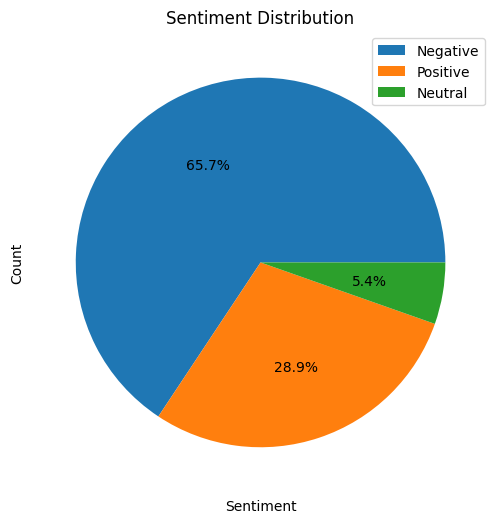

In [6]:
# Data description distribution
plt.figure(figsize=(10, 6))

plt.pie(cleaned_delta_df['sentiment'].value_counts(), autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
labels = ['Negative', 'Positive', 'Neutral']
plt.legend(labels)
plt.show()


### Train on evenly distributed data

### Preprocessing Data ###

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download all required NLTK resources
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

# Initialize tools
wn = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add any additional stopwords you want to remove
additional_stops = {'to', 'the', 'and', 'a', 'an', 'in', 'on', 'at', 'for', 'of', 'with', 'delta'}
stop_words.update(additional_stops)

def process_text(text):
    try:
        # Convert to string if not already
        text = str(text)
        
        # Simple word tokenization (split by whitespace)
        tokens = text.split()
        
        # Convert to lowercase
        tokens = [word.lower() for word in tokens]
        
        # Remove stopwords and non-alphabetic tokens
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        
        # Lemmatize
        tokens = [wn.lemmatize(word) for word in tokens]
        
        # Join back into text
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""  # Return empty string on error

# Process reviews
cleaned_delta_df['processed_reviews'] = cleaned_delta_df['reviews'].apply(process_text)

# Now use TF-IDF on the processed reviews
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(cleaned_delta_df['processed_reviews'])

[nltk_data] Downloading package punkt to /Users/godwins/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/godwins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/godwins/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/godwins/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Model Training ###

In [8]:
from sklearn.model_selection import GridSearchCV

y = cleaned_delta_df['sentiment'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Fine Tuning Function ###
def fine_tune_options(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

### Fine Tuning Models ###
cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train)
fine_tune_options(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 100}

0.657 (+/-0.003) for {'max_depth': 2, 'n_estimators': 5}
0.657 (+/-0.002) for {'max_depth': 2, 'n_estimators': 50}
0.657 (+/-0.002) for {'max_depth': 2, 'n_estimators': 100}
0.645 (+/-0.01) for {'max_depth': 10, 'n_estimators': 5}
0.658 (+/-0.001) for {'max_depth': 10, 'n_estimators': 50}
0.656 (+/-0.003) for {'max_depth': 10, 'n_estimators': 100}
0.638 (+/-0.036) for {'max_depth': 20, 'n_estimators': 5}
0.656 (+/-0.005) for {'max_depth': 20, 'n_estimators': 50}
0.657 (+/-0.004) for {'max_depth': 20, 'n_estimators': 100}
0.577 (+/-0.039) for {'max_depth': None, 'n_estimators': 5}
0.649 (+/-0.013) for {'max_depth': None, 'n_estimators': 50}
0.659 (+/-0.011) for {'max_depth': None, 'n_estimators': 100}


In [9]:
### Train with best parameters ###
model = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=42)
model.fit(X_train,y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Tuned Accuracy: {accuracy:.2f}")
print(f"Tuned Classification Report:\n{report}")


Tuned Accuracy: 0.65
Tuned Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      1.00      0.79       352
     Neutral       0.00      0.00      0.00        32
    Positive       0.33      0.01      0.01       154

    accuracy                           0.65       538
   macro avg       0.33      0.33      0.27       538
weighted avg       0.52      0.65      0.52       538



### Visualizing Model ###

In [10]:
def plot_feature_importance(model,feature_names, n_features=10, figsize=(10,6)):
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot top n_features
    plt.figure(figsize=figsize)
    plt.title('Top Feature Importances in Sentiment Analysis')
    
    # Plot only top n_features
    n = min(n_features, len(importances))
    plt.bar(range(n), 
            importances[indices][:n],
            align='center')
    
    # Use actual words as labels
    plt.xticks(range(n), 
               [feature_names[i] for i in indices[:n]], 
               rotation=45,
               ha='right')
    
    plt.xlabel('Words')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

def plot_decision_tree(model, max_depth=3, figsize=(20,10)):
    plt.figure(figsize=figsize)
    # Get a single tree from the forest
    tree = model.estimators_[0]
    
    # Create feature names for all dimensions
    feature_names = [f'dim_{i}' for i in range(model.n_features_in_)]
    
    plot_tree(tree, 
             feature_names=feature_names,
             max_depth=max_depth,
             filled=True,
             rounded=True)
    plt.show()

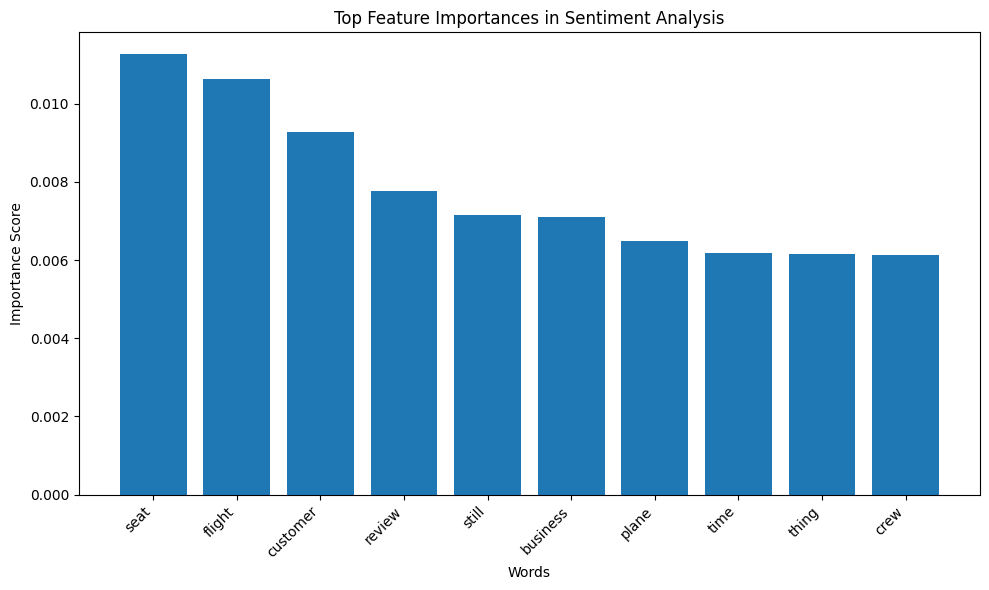

In [12]:
# Visualize feature importance (top 10 features)
feature_names = vectorizer.get_feature_names_out()

plot_feature_importance(
    model=model,
    feature_names=feature_names
)

# Visualize a single tree from the forest --- Not very Informative at the moment
# plot_decision_tree(
#     model=model,
#     max_depth=3
# )

### What other factors affect sentiment? ###




In [39]:
from sklearn.preprocessing import LabelEncoder
# display(cleaned_delta_df.head())

# Create label encoder
le = LabelEncoder()

# Prepare features (X)
# Encode categorical column
X = le.fit_transform(cleaned_delta_df.iloc[:,3]).reshape(-1, 1)
y = cleaned_delta_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Tuned Accuracy: {accuracy:.2f}")
print(f"Tuned Classification Report:\n{report}")

Tuned Accuracy: 0.65
Tuned Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      1.00      0.79       352
     Neutral       0.00      0.00      0.00        32
    Positive       0.00      0.00      0.00       154

    accuracy                           0.65       538
   macro avg       0.22      0.33      0.26       538
weighted avg       0.43      0.65      0.52       538



In [40]:
print(cleaned_delta_df.iloc[:,3].unique())

['economy class' 'premium economy' 'first class' 'business class']


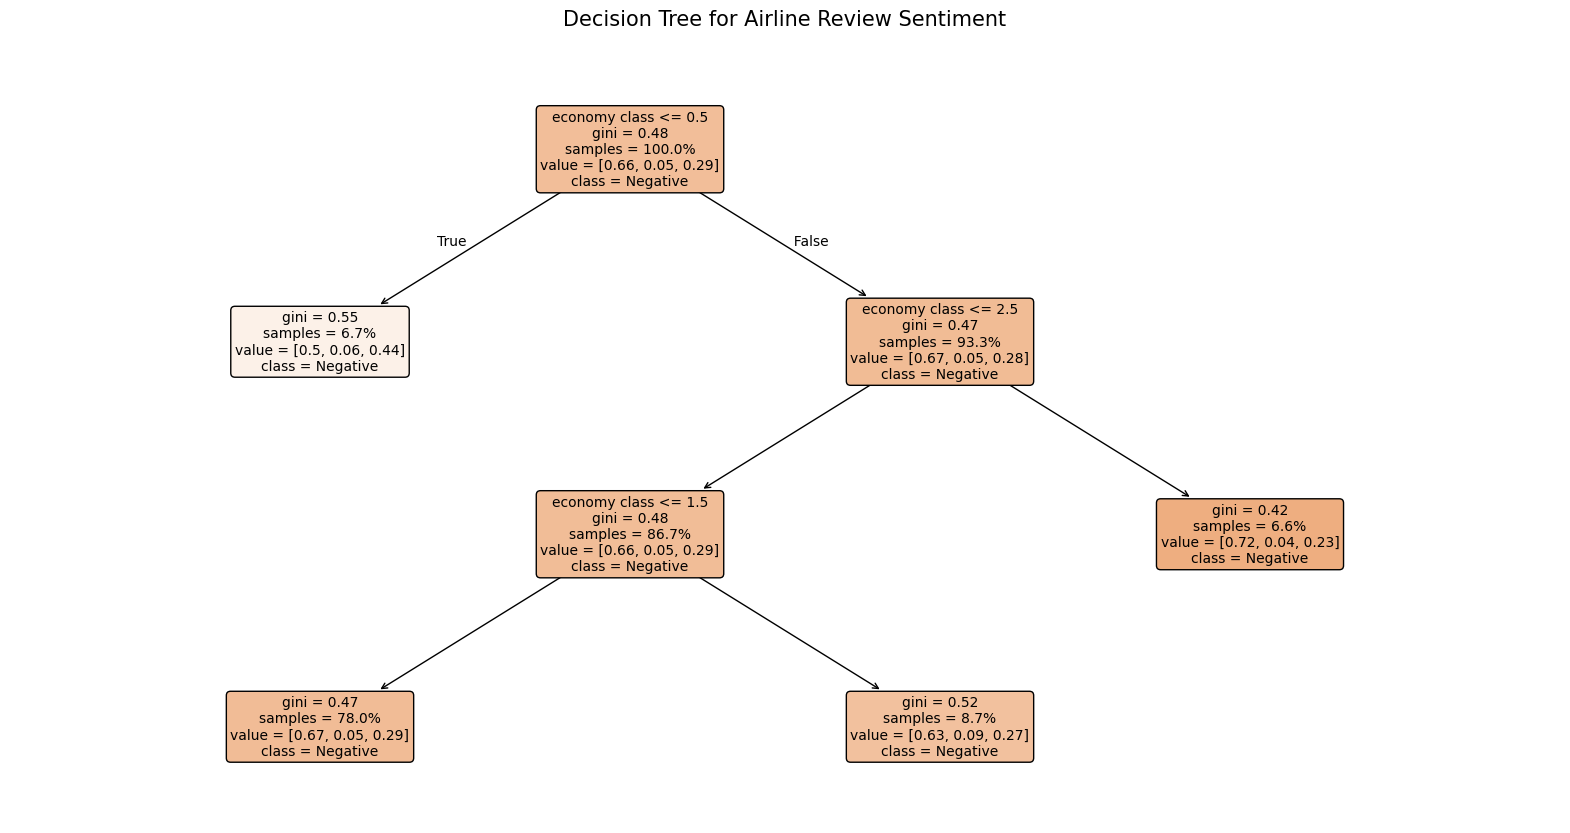

In [33]:
def plot_decision_tree(model, feature_names=None, class_names=None, max_depth=3, figsize=(20,10)):
    """
    Plot a more interpretable decision tree
    
    Parameters:
    -----------
    model : RandomForestClassifier
        The trained model
    feature_names : list
        List of feature names (e.g., ['Seat Type', 'Route', etc.])
    class_names : list
        List of class names (e.g., ['Negative', 'Neutral', 'Positive'])
    max_depth : int
        Maximum depth of tree to display
    figsize : tuple
        Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Get a single tree from the forest
    tree = model.estimators_[0]
    
    # If feature names not provided, create generic ones
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(model.n_features_in_)]
    
    # If class names not provided, use sentiment labels
    if class_names is None:
        class_names = ['Negative', 'Neutral', 'Positive']

     # Plot the tree
    plot_tree(
        tree,
        feature_names=feature_names,
        class_names=class_names,
        max_depth=max_depth,
        filled=True,
        rounded=True,
        fontsize=10,
        proportion=True,  # Show proportions instead of counts
        precision=2  # Round decimals to 2 places
    )
    
    plt.title('Decision Tree for Airline Review Sentiment', pad=20, size=15)
    plt.show()
# Plot the tree
plot_decision_tree(
    model=model,
    feature_names=feature_names,
    class_names=['Negative', 'Neutral', 'Positive'],
    max_depth=3
)
   

## Exploring Seat Type ###


Summary Statistics:
                 count  mean   std  min  max
seat_type                                   
business class     187  4.48  3.60    0   10
economy class     2082  3.81  3.44    0   10
first class        223  3.97  3.53    0   10
premium economy    197  3.68  3.45    0   10


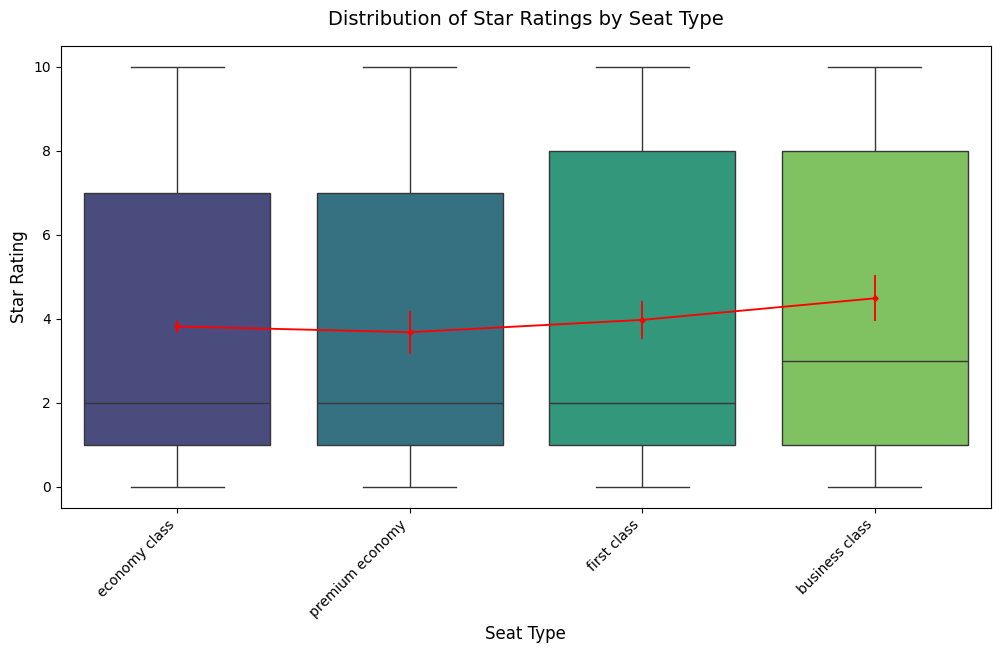

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_delta_df = cleaned_delta_df.copy()
plot_delta_df['seat_type'] = cleaned_delta_df.iloc[:,3]

# Create figure with larger size
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(data=plot_delta_df, 
            x='seat_type',
            y='star rating',
            palette='viridis')

# Customize the plot
plt.title('Distribution of Star Ratings by Seat Type', pad=15, size=14)
plt.xlabel('Seat Type', size=12)
plt.ylabel('Star Rating', size=12)
plt.xticks(rotation=45, ha='right')

# Add mean points
sns.pointplot(data=plot_delta_df,
             x='seat_type',
             y='star rating',
             color='red',
             markers='D',
             scale=0.5)


# Add statistical summary
print("\nSummary Statistics:")
summary = plot_delta_df.groupby('seat_type')['star rating'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max'
]).round(2)
print(summary)

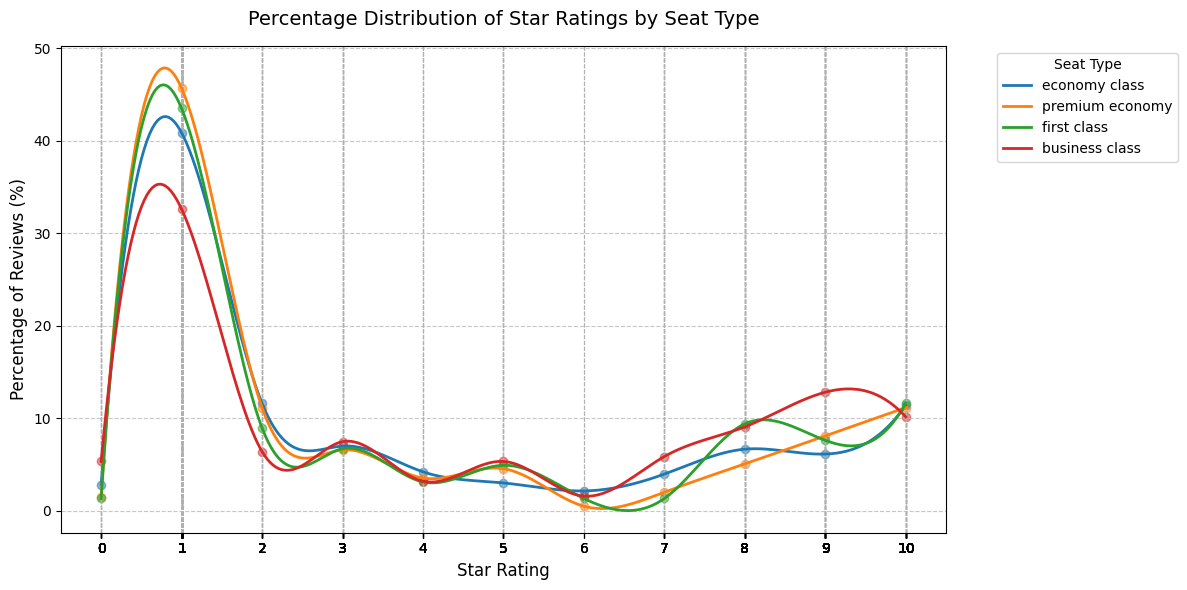


Summary Statistics by Seat Type:
                 count  mean  median
seat_type                           
business class     187  4.48     3.0
economy class     2082  3.81     2.0
first class        223  3.97     2.0
premium economy    197  3.68     2.0


In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Create figure
plt.figure(figsize=(12, 6))

# Calculate and plot smooth percentage distribution for each seat type
for seat_type in plot_delta_df['seat_type'].unique():
    # Get data for this seat type
    seat_data = plot_delta_df[plot_delta_df['seat_type'] == seat_type]
    
    # Calculate distribution as percentages
    distribution = seat_data['star rating'].value_counts()
    distribution_pct = (distribution / distribution.sum() * 100).sort_index()
    
    # Create smooth line using interpolation
    X = distribution_pct.index.values
    Y = distribution_pct.values
    
    # Create smoother points for interpolation
    X_smooth = np.linspace(X.min(), X.max(), 300)
    spl = make_interp_spline(X, Y, k=3)  # k=3 for cubic spline
    Y_smooth = spl(X_smooth)
    
    # Plot smooth line
    plt.plot(X_smooth, Y_smooth, 
             label=seat_type,
             linewidth=2)
    
    # Add points for actual data
    plt.scatter(X, Y,
                alpha=0.5)

# Customize the plot
plt.title('Percentage Distribution of Star Ratings by Seat Type', pad=15, size=14)
plt.xlabel('Star Rating', size=12)
plt.ylabel('Percentage of Reviews (%)', size=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Seat Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-axis limits and ticks
# plt.xlim(0.8, 5.2)  # Add some padding
plt.xticks(seat_data['star rating'])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Seat Type:")
summary = plot_delta_df.groupby('seat_type')['star rating'].agg([
    'count',
    'mean',
    'median'
]).round(2)
print(summary)

## Exploring Travel Type ###

In [99]:
# print(cleaned_delta_df.iloc[:,5].unique())
df = cleaned_delta_df.copy()
df = df[df.iloc[:,5] != '']

print(df.iloc[:,5].unique())


['solo leisure' 'business' 'family leisure' 'couple leisure']



Summary Statistics:
                count  mean   std  min  max
travel_type                                
business          435  3.75  3.38    1   10
couple leisure    534  3.65  3.41    1   10
family leisure    555  3.55  3.32    1   10
solo leisure      758  3.64  3.37    1   10


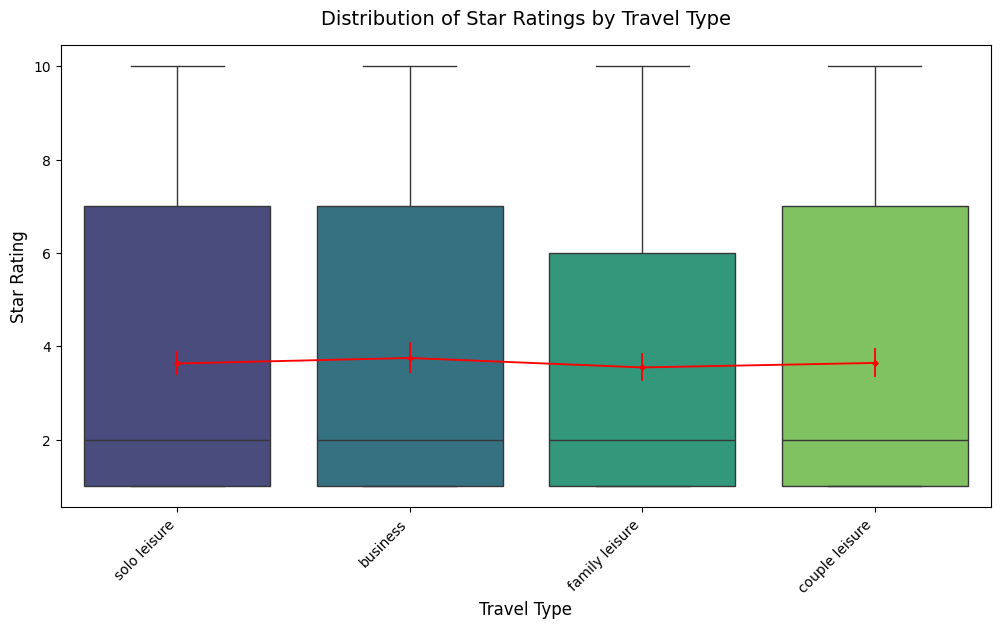

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_delta_df = df.copy()
plot_delta_df['travel_type'] = df.iloc[:,5]

# Create figure with larger size
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(data=plot_delta_df, 
            x='travel_type',
            y='star rating',
            palette='viridis')

# Customize the plot
plt.title('Distribution of Star Ratings by Travel Type', pad=15, size=14)
plt.xlabel('Travel Type', size=12)
plt.ylabel('Star Rating', size=12)
plt.xticks(rotation=45, ha='right')

# Add mean points
sns.pointplot(data=plot_delta_df,
             x='travel_type',
             y='star rating',
             color='red',
             markers='D',
             scale=0.5)


# Add statistical summary
print("\nSummary Statistics:")
summary = plot_delta_df.groupby('travel_type')['star rating'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max'
]).round(2)
print(summary)

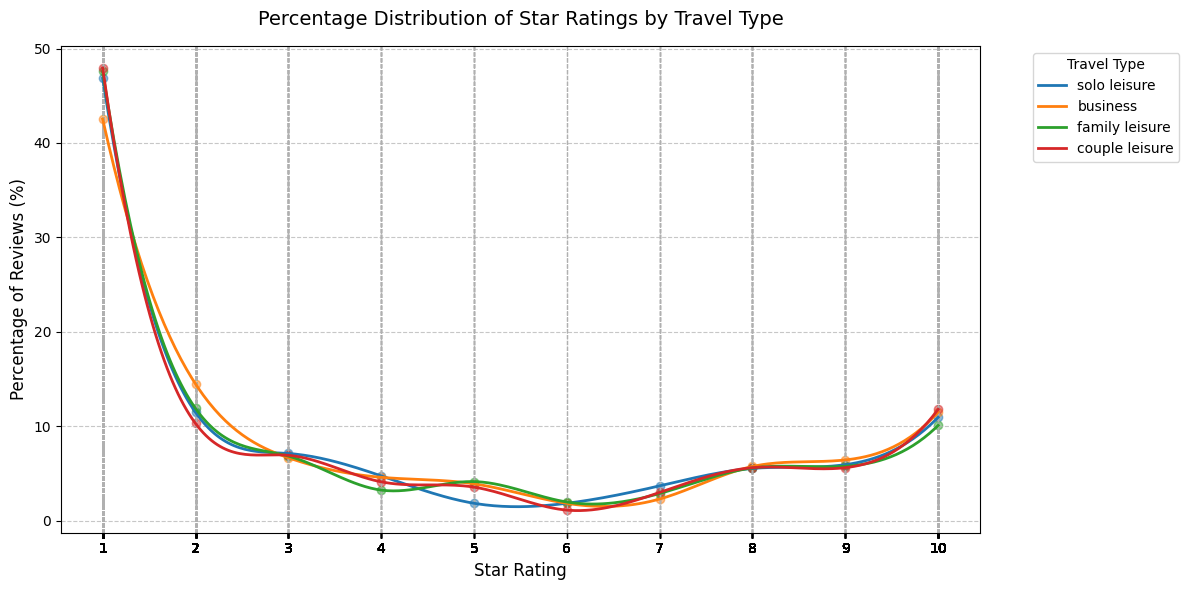


Summary Statistics by Travel Type:
                count  mean  median
travel_type                        
business          435  3.75     2.0
couple leisure    534  3.65     2.0
family leisure    555  3.55     2.0
solo leisure      758  3.64     2.0


In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Create figure
plt.figure(figsize=(12, 6))

# Calculate and plot smooth percentage distribution for each seat type
for travel_type in plot_delta_df['travel_type'].unique():
    # Get data for this seat type
    travel_data = plot_delta_df[plot_delta_df['travel_type'] == travel_type]
    
    # Calculate distribution as percentages
    distribution = travel_data['star rating'].value_counts()
    distribution_pct = (distribution / distribution.sum() * 100).sort_index()
    
    # Create smooth line using interpolation
    X = distribution_pct.index.values
    Y = distribution_pct.values
    
    # Create smoother points for interpolation
    X_smooth = np.linspace(X.min(), X.max(), 300)
    spl = make_interp_spline(X, Y, k=3)  # k=3 for cubic spline
    Y_smooth = spl(X_smooth)
    
    # Plot smooth line
    plt.plot(X_smooth, Y_smooth, 
             label=travel_type,
             linewidth=2)
    
    # Add points for actual data
    plt.scatter(X, Y,
                alpha=0.5)

# Customize the plot
plt.title('Percentage Distribution of Star Ratings by Travel Type', pad=15, size=14)
plt.xlabel('Star Rating', size=12)
plt.ylabel('Percentage of Reviews (%)', size=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Travel Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-axis limits and ticks
# plt.xlim(0.8, 5.2)  # Add some padding
plt.xticks(travel_data['star rating'])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Travel Type:")
summary = plot_delta_df.groupby('travel_type')['star rating'].agg([
    'count',
    'mean',
    'median'
]).round(2)
print(summary)